In [1]:
import os
os.chdir('../')

In [34]:
%reload_ext tensorboard
%tensorboard --logdir "models/disentangle_losses_v1/"

In [3]:
# enable auto-reload of sources
%load_ext autoreload
%autoreload 2
# import tensorboard backend
from tensorboard.backend.event_processing import event_accumulator

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
base_dir = '/home/xlv0877/proj_home/dl/models/disentangle_losses_v1/'

In [4]:
# set log dir of harmonized model
harm_log_dir = 'logs/harm/lightning_logs/version_5/'
raw_log_dir = 'logs/raw/lightning_logs/baba/'
raw_log_dir = 'logs/raw/lightning_logs/version_26/'
raw_scanvi_log_dir = 'logs/scanvi/lightning_logs/version_22'
log_dir = raw_scanvi_log_dir

In [35]:
mode = 'rl+kl'
version = 0
log_dir = f'{base_dir}/{mode}/lightning_logs/version_{version}'
# Load the event accumulator
event_acc = event_accumulator.EventAccumulator(log_dir)
event_acc.Reload()

# Check available tags (e.g., scalars, histograms, images)
tags = event_acc.Tags()

In [36]:
import pandas as pd

results = []
tags = [t for t in tags['scalars'] if t != 'hp_metric']
for tag in tags:
    scalar_data = event_acc.Scalars(tag)
    # Extract the step and value from the scalar data
    steps = [entry.step for entry in scalar_data]
    values = [entry.value for entry in scalar_data]
    # Store the data in the dictionary
    results.append(pd.DataFrame({'tag': tag, 'step': steps, 'value': values}))

results = pd.concat(results)

### Plot metrics

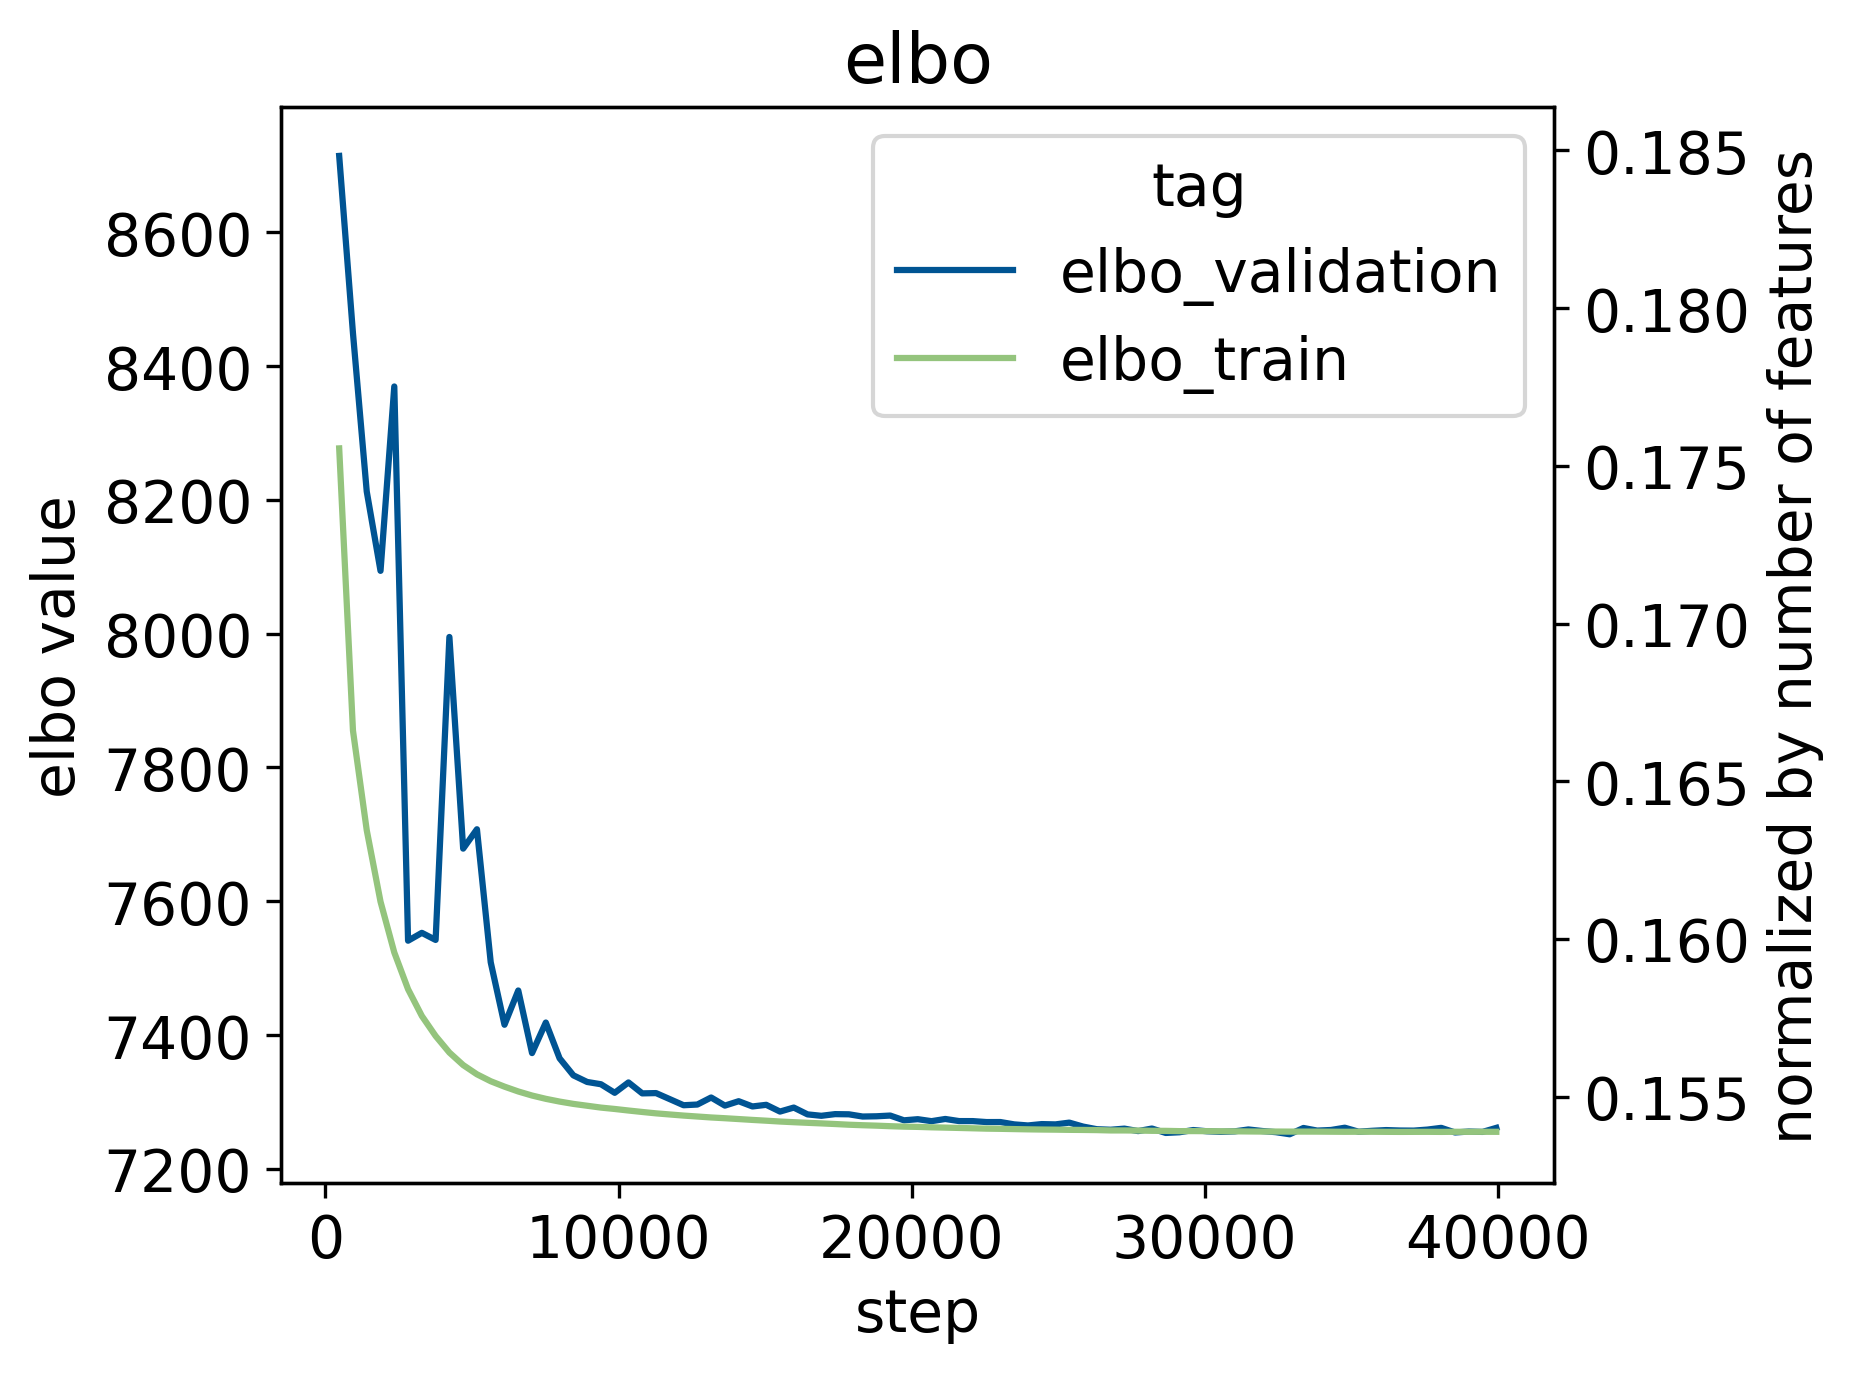

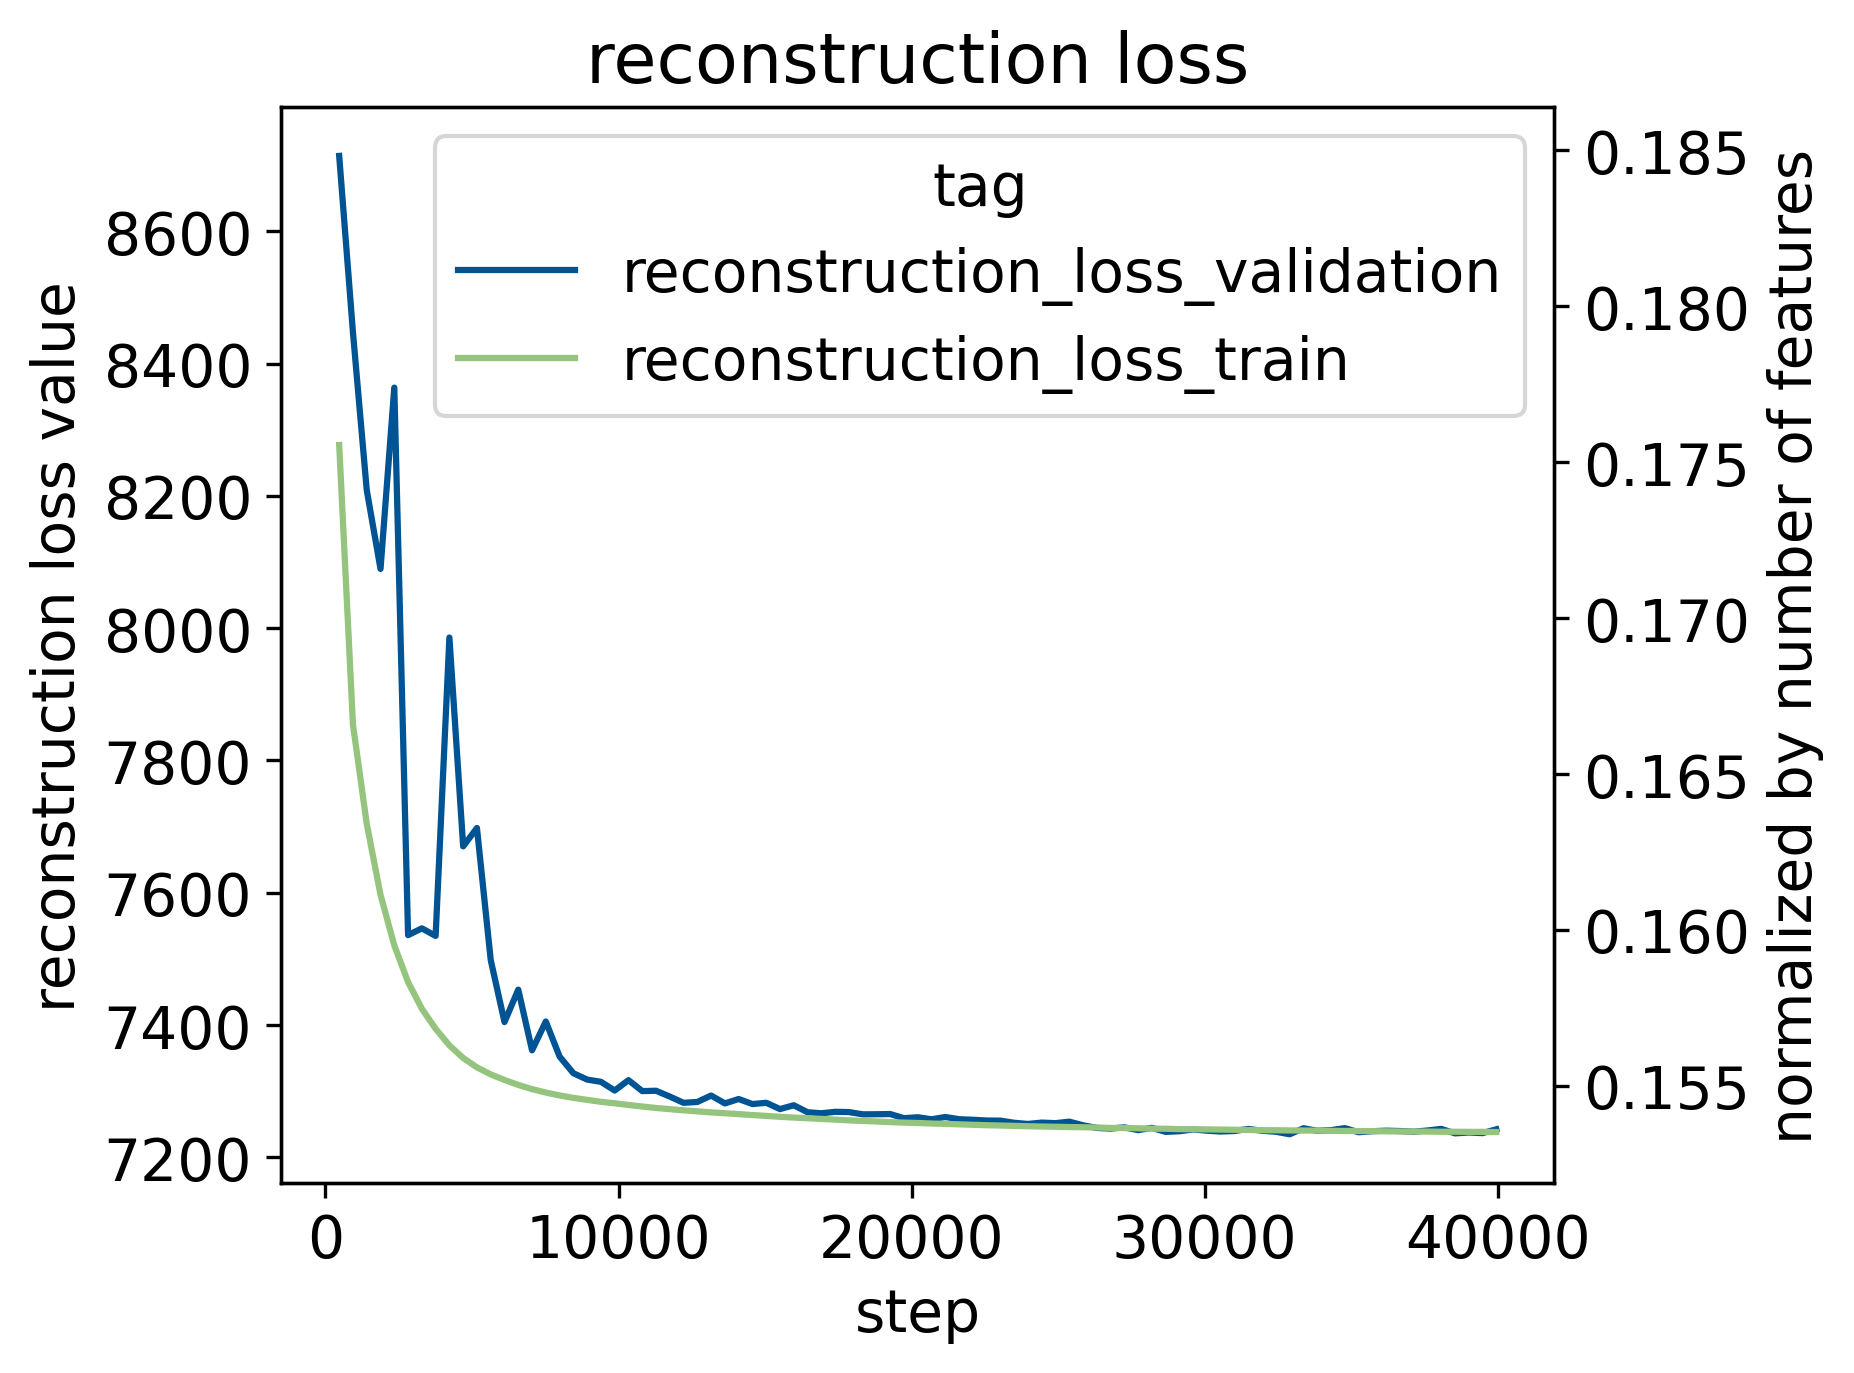

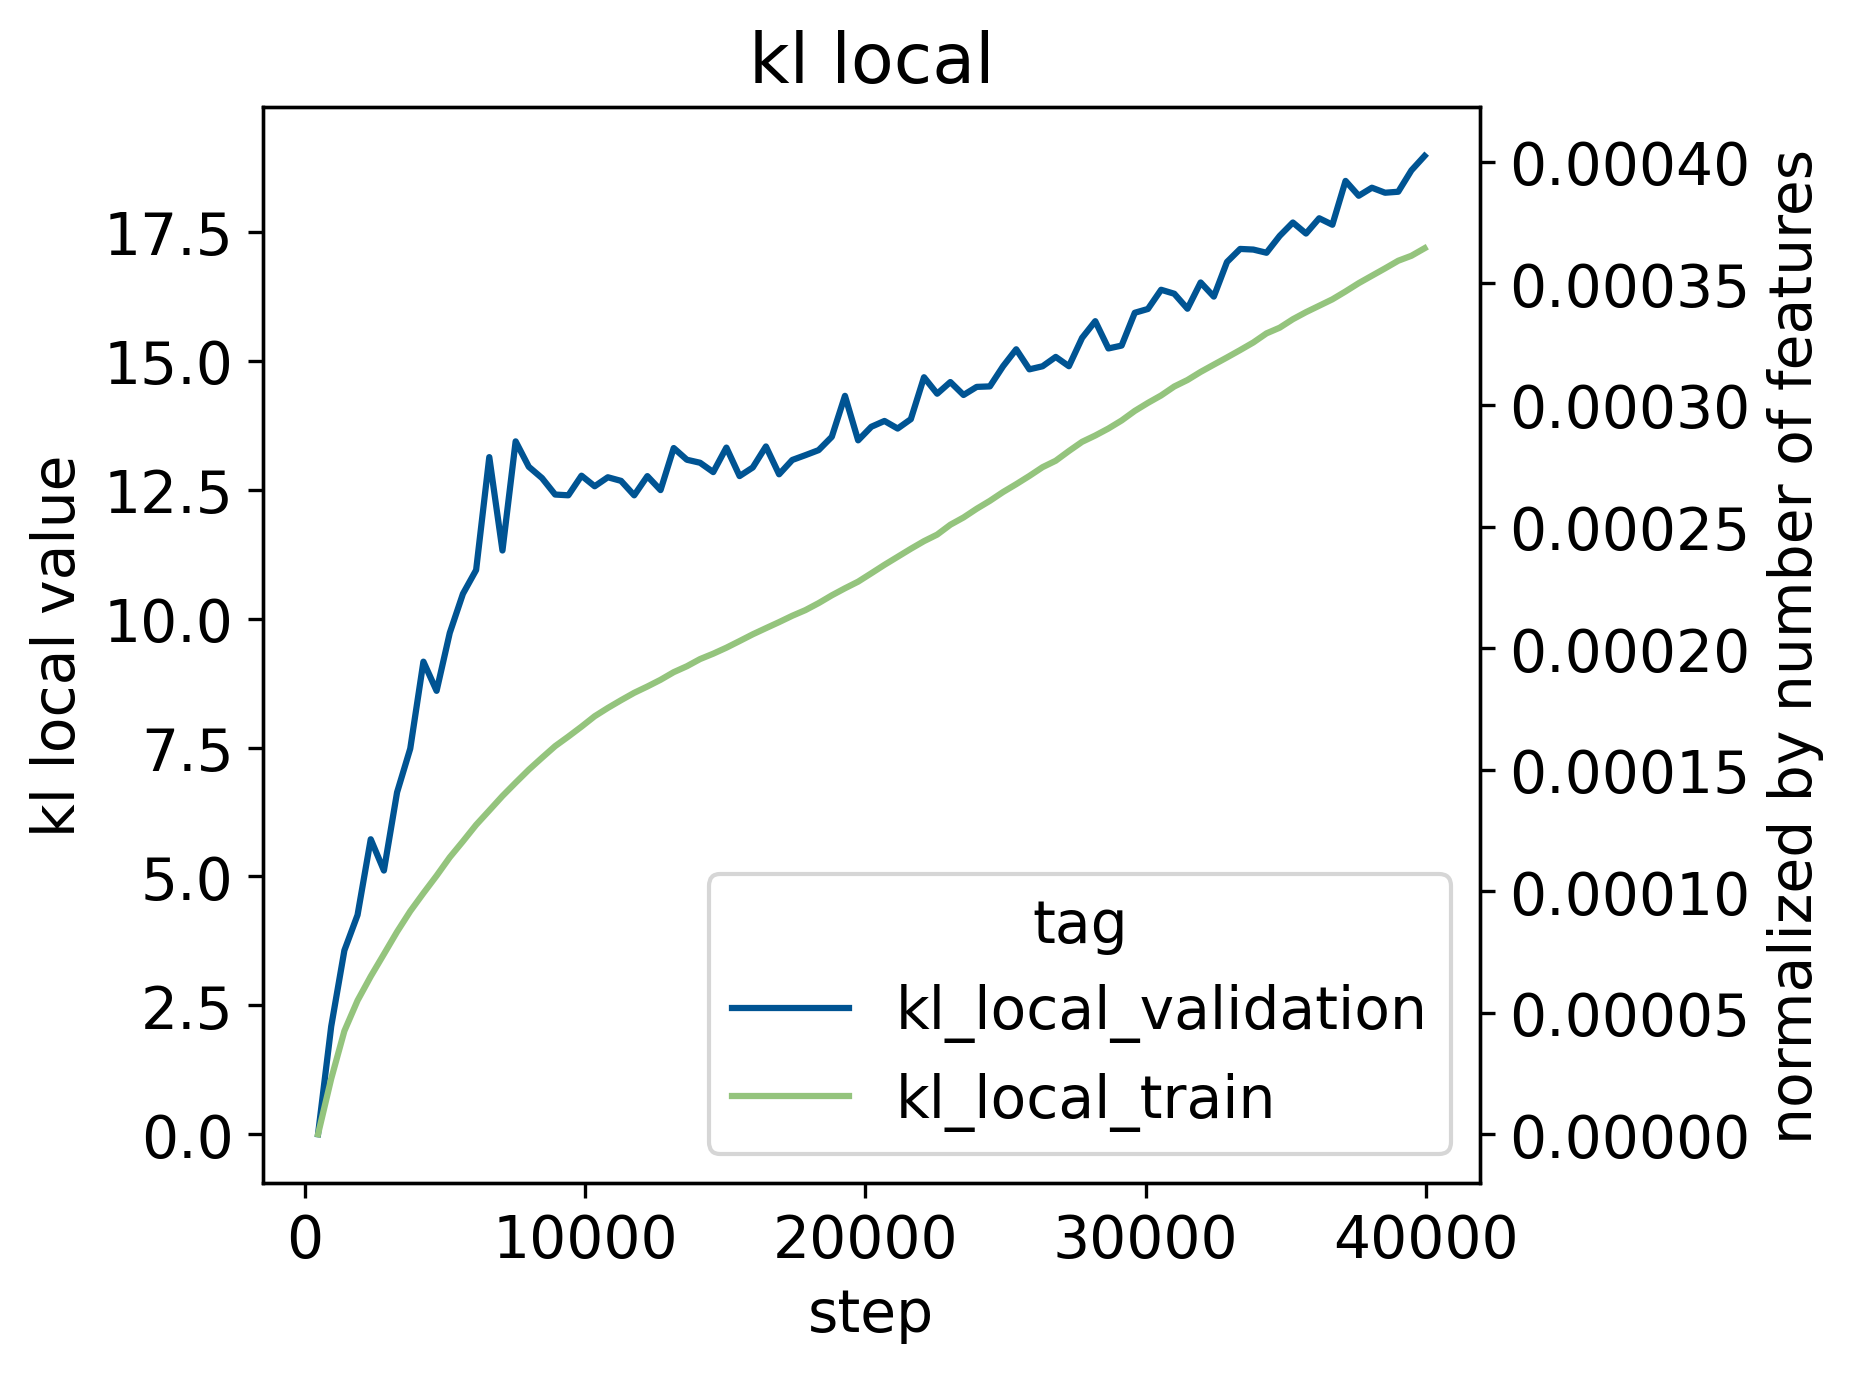

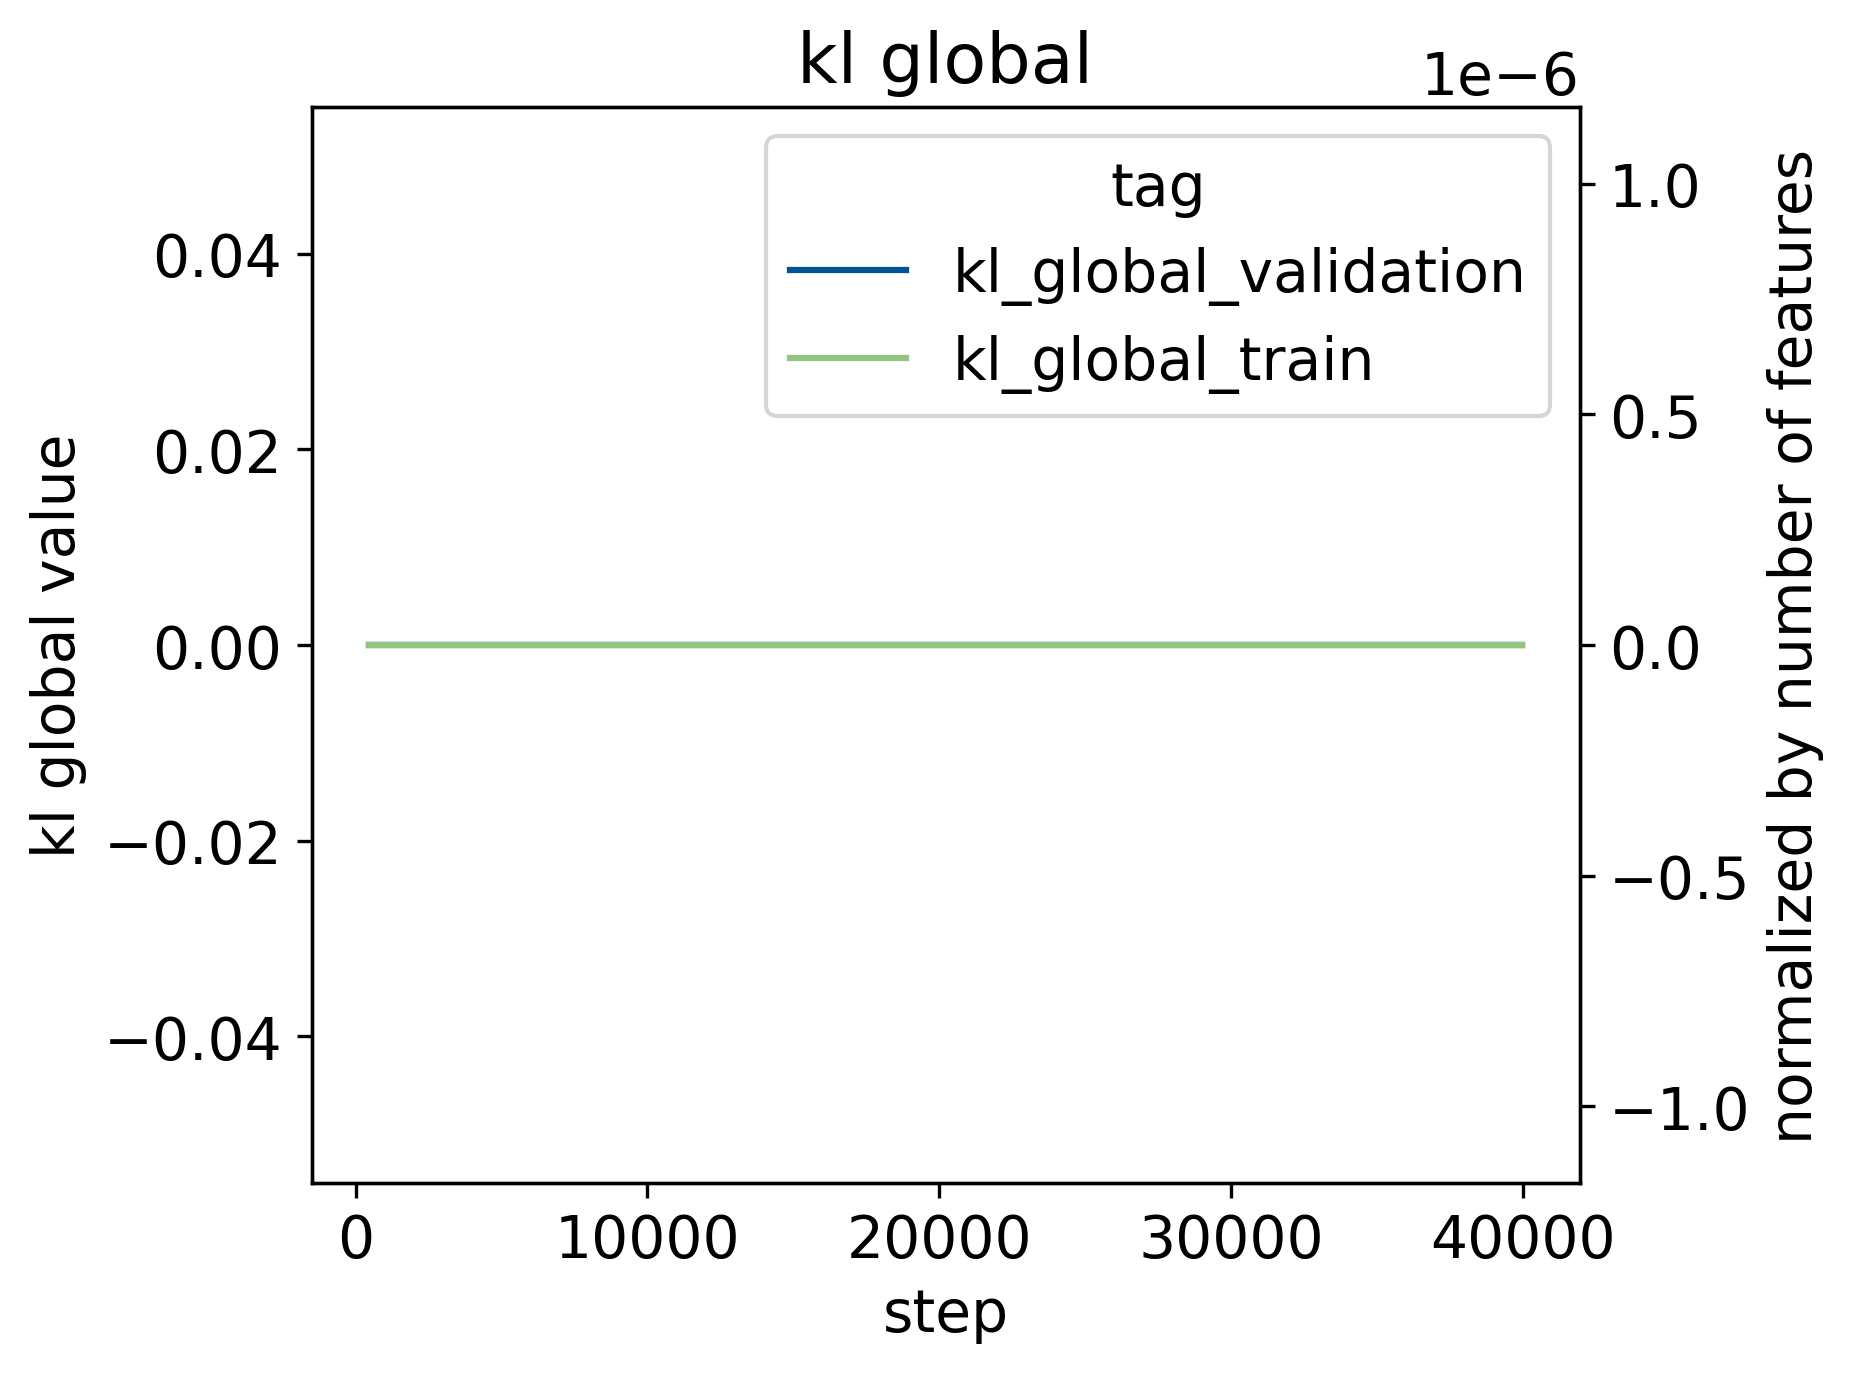

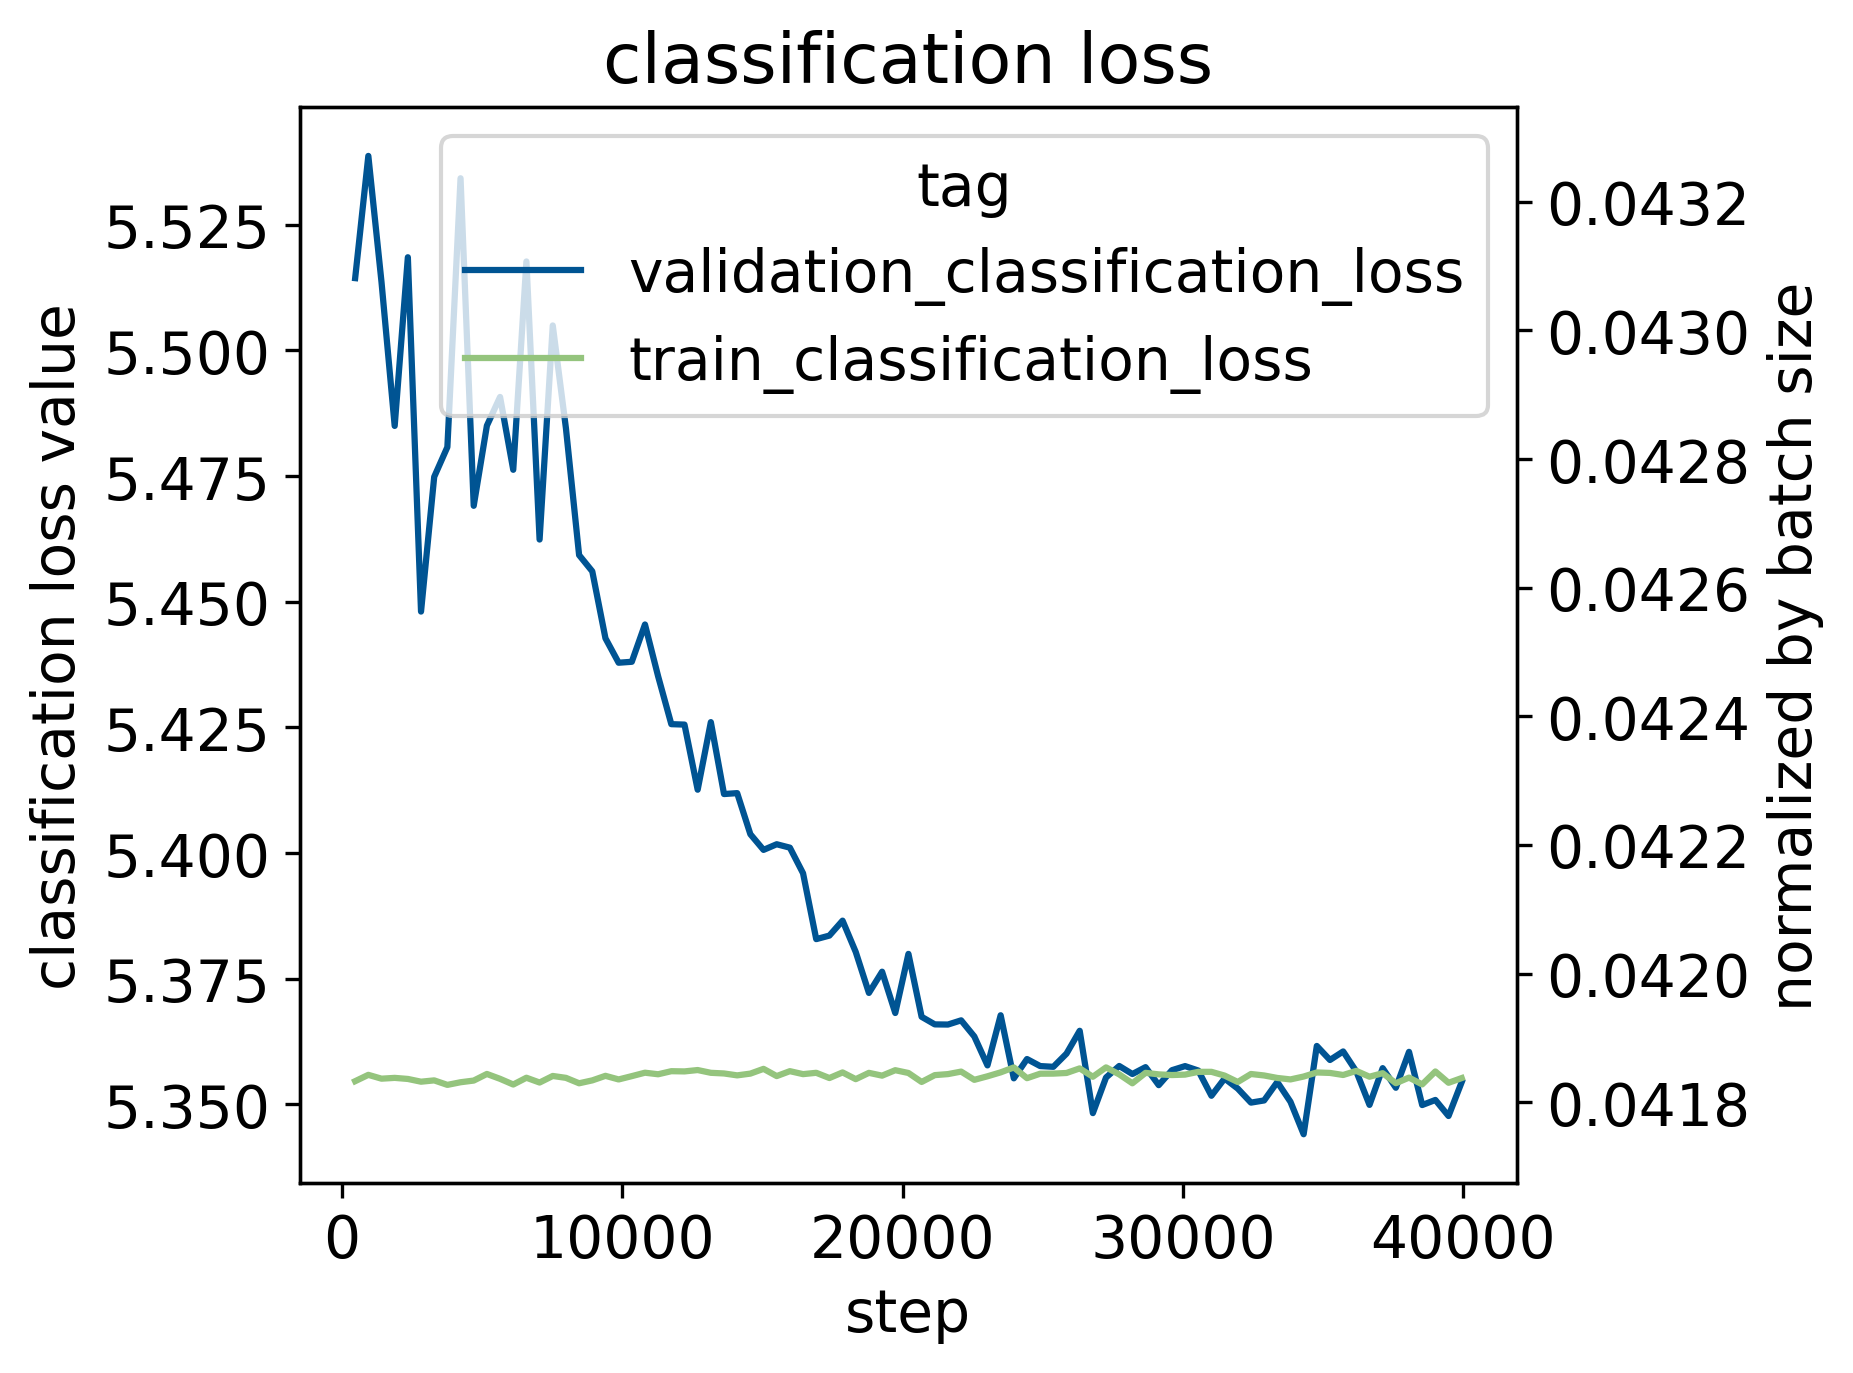

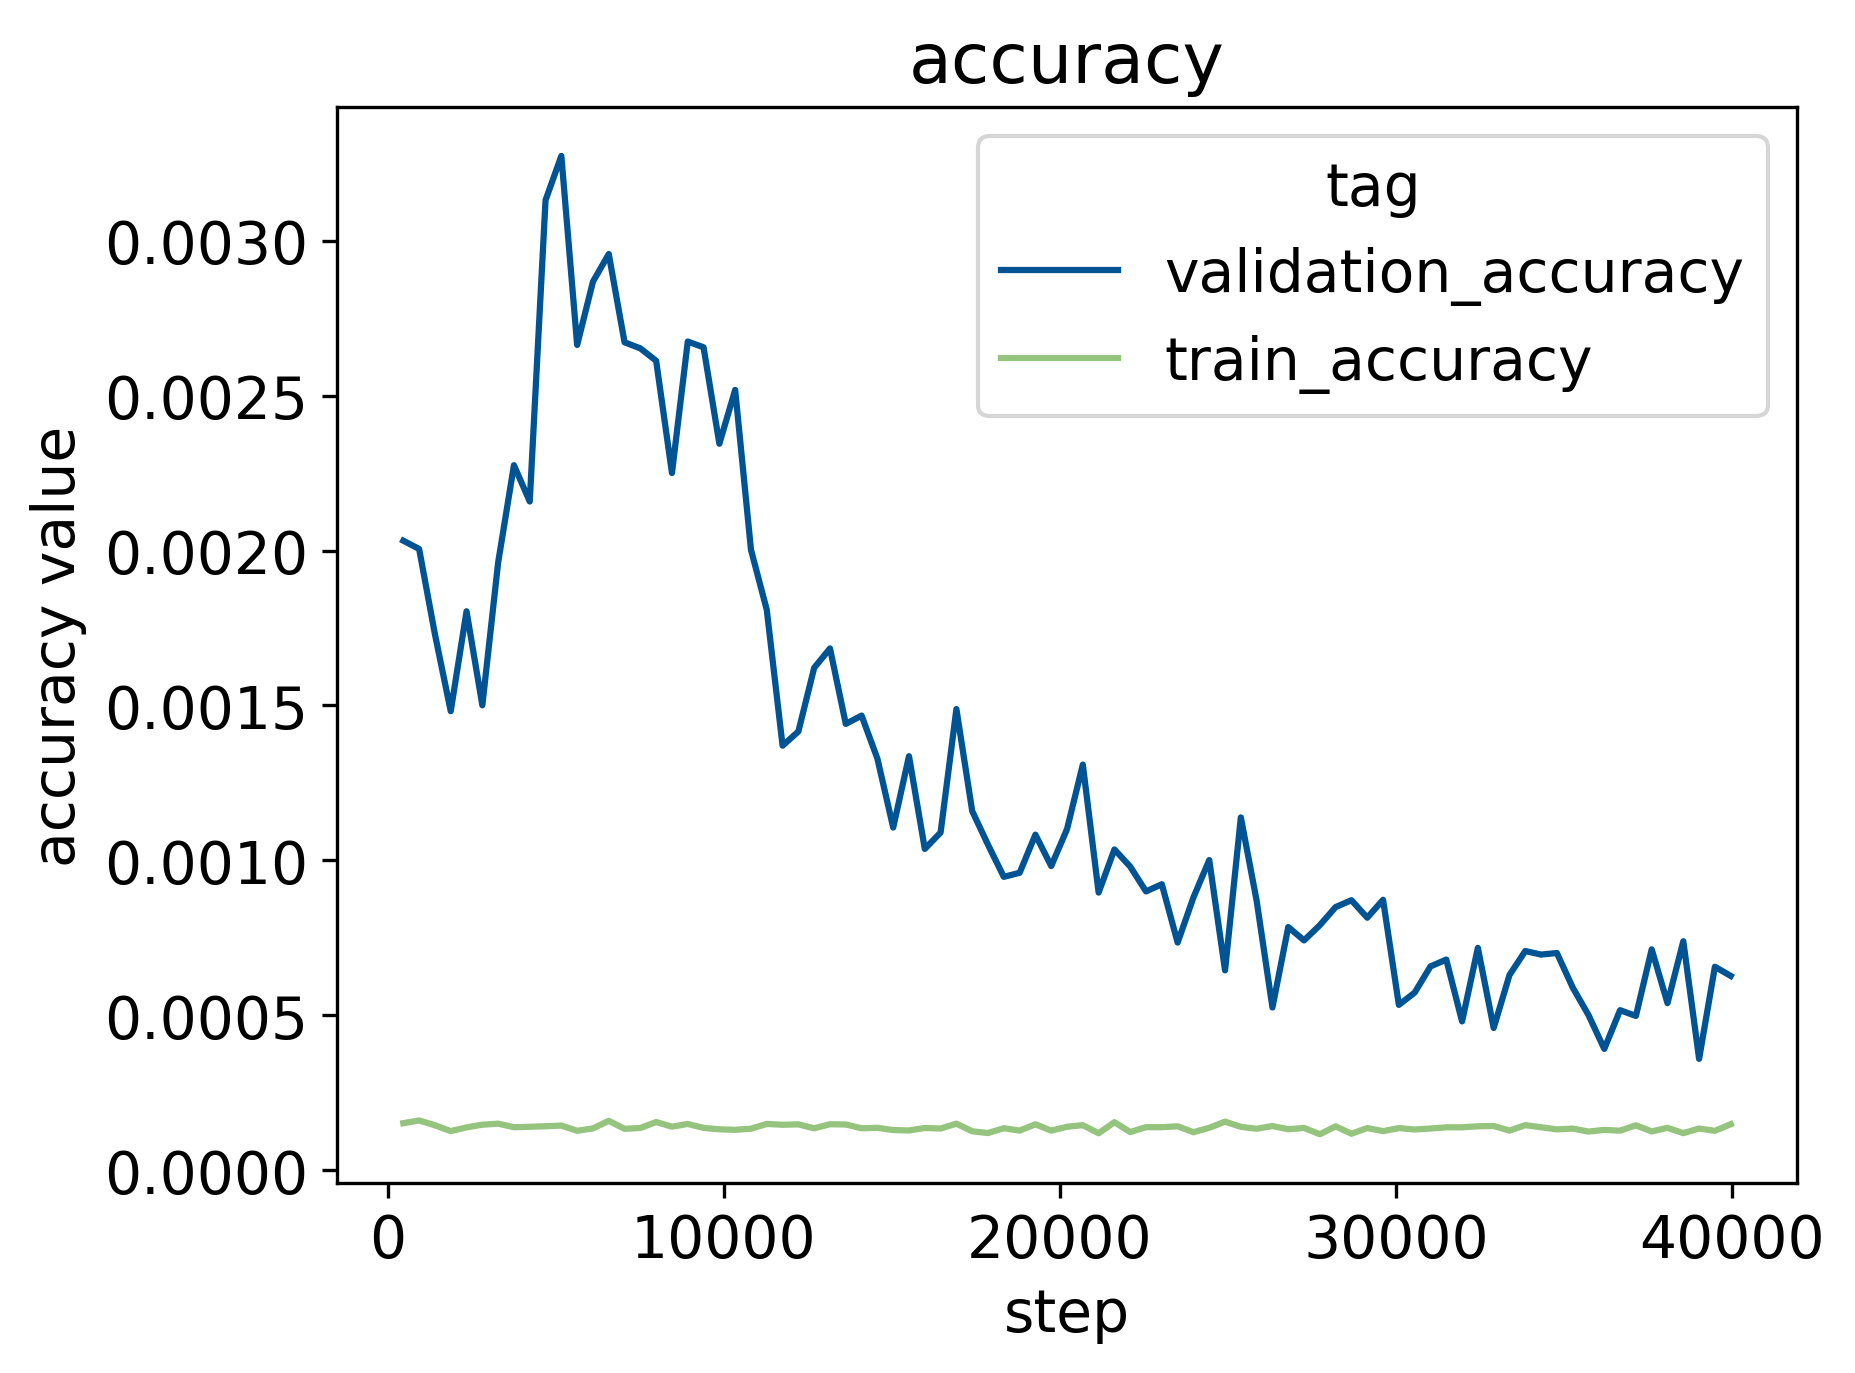

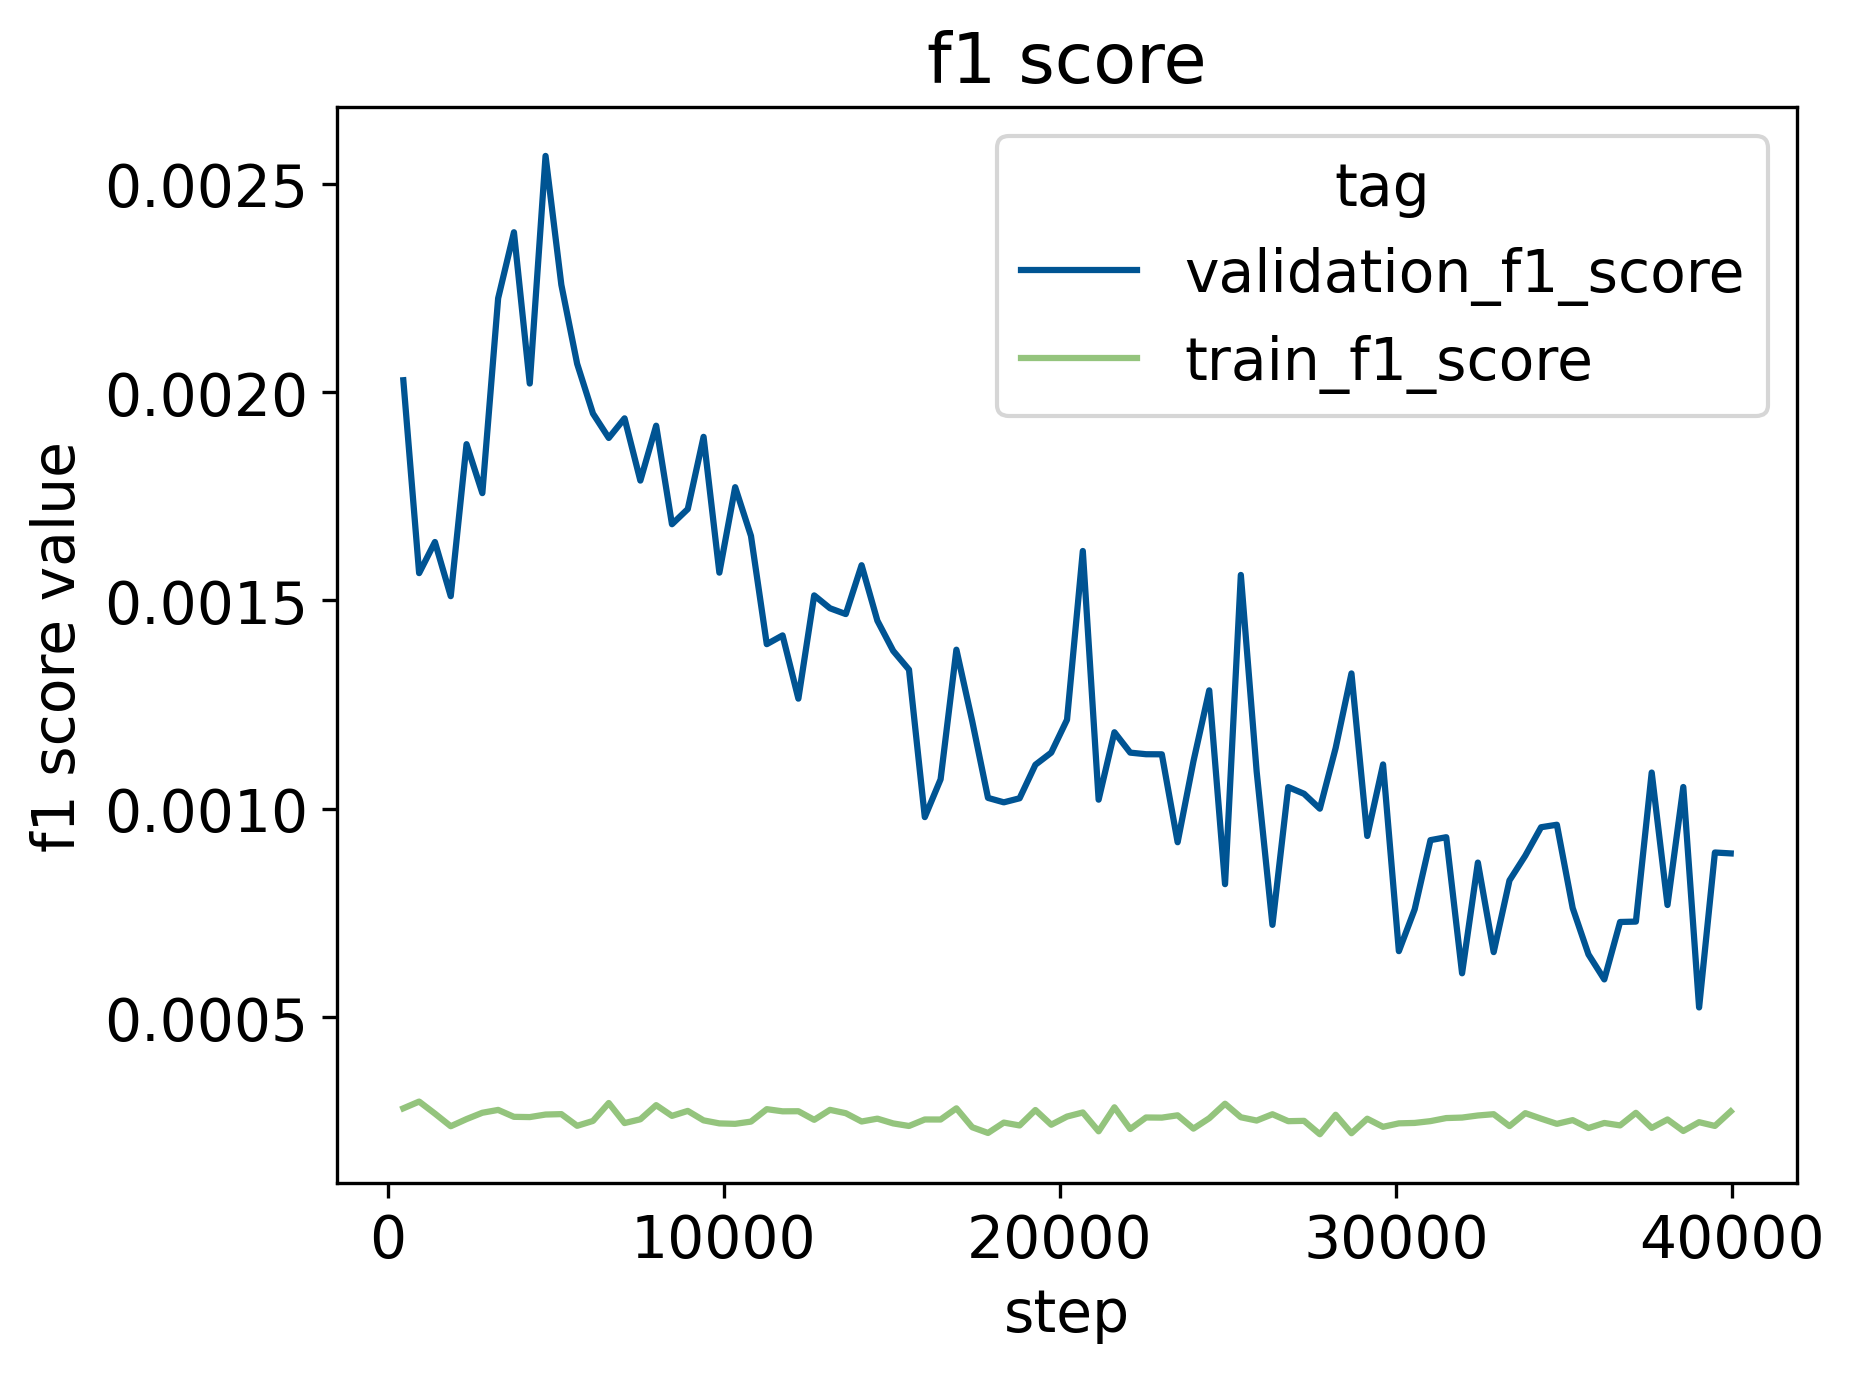

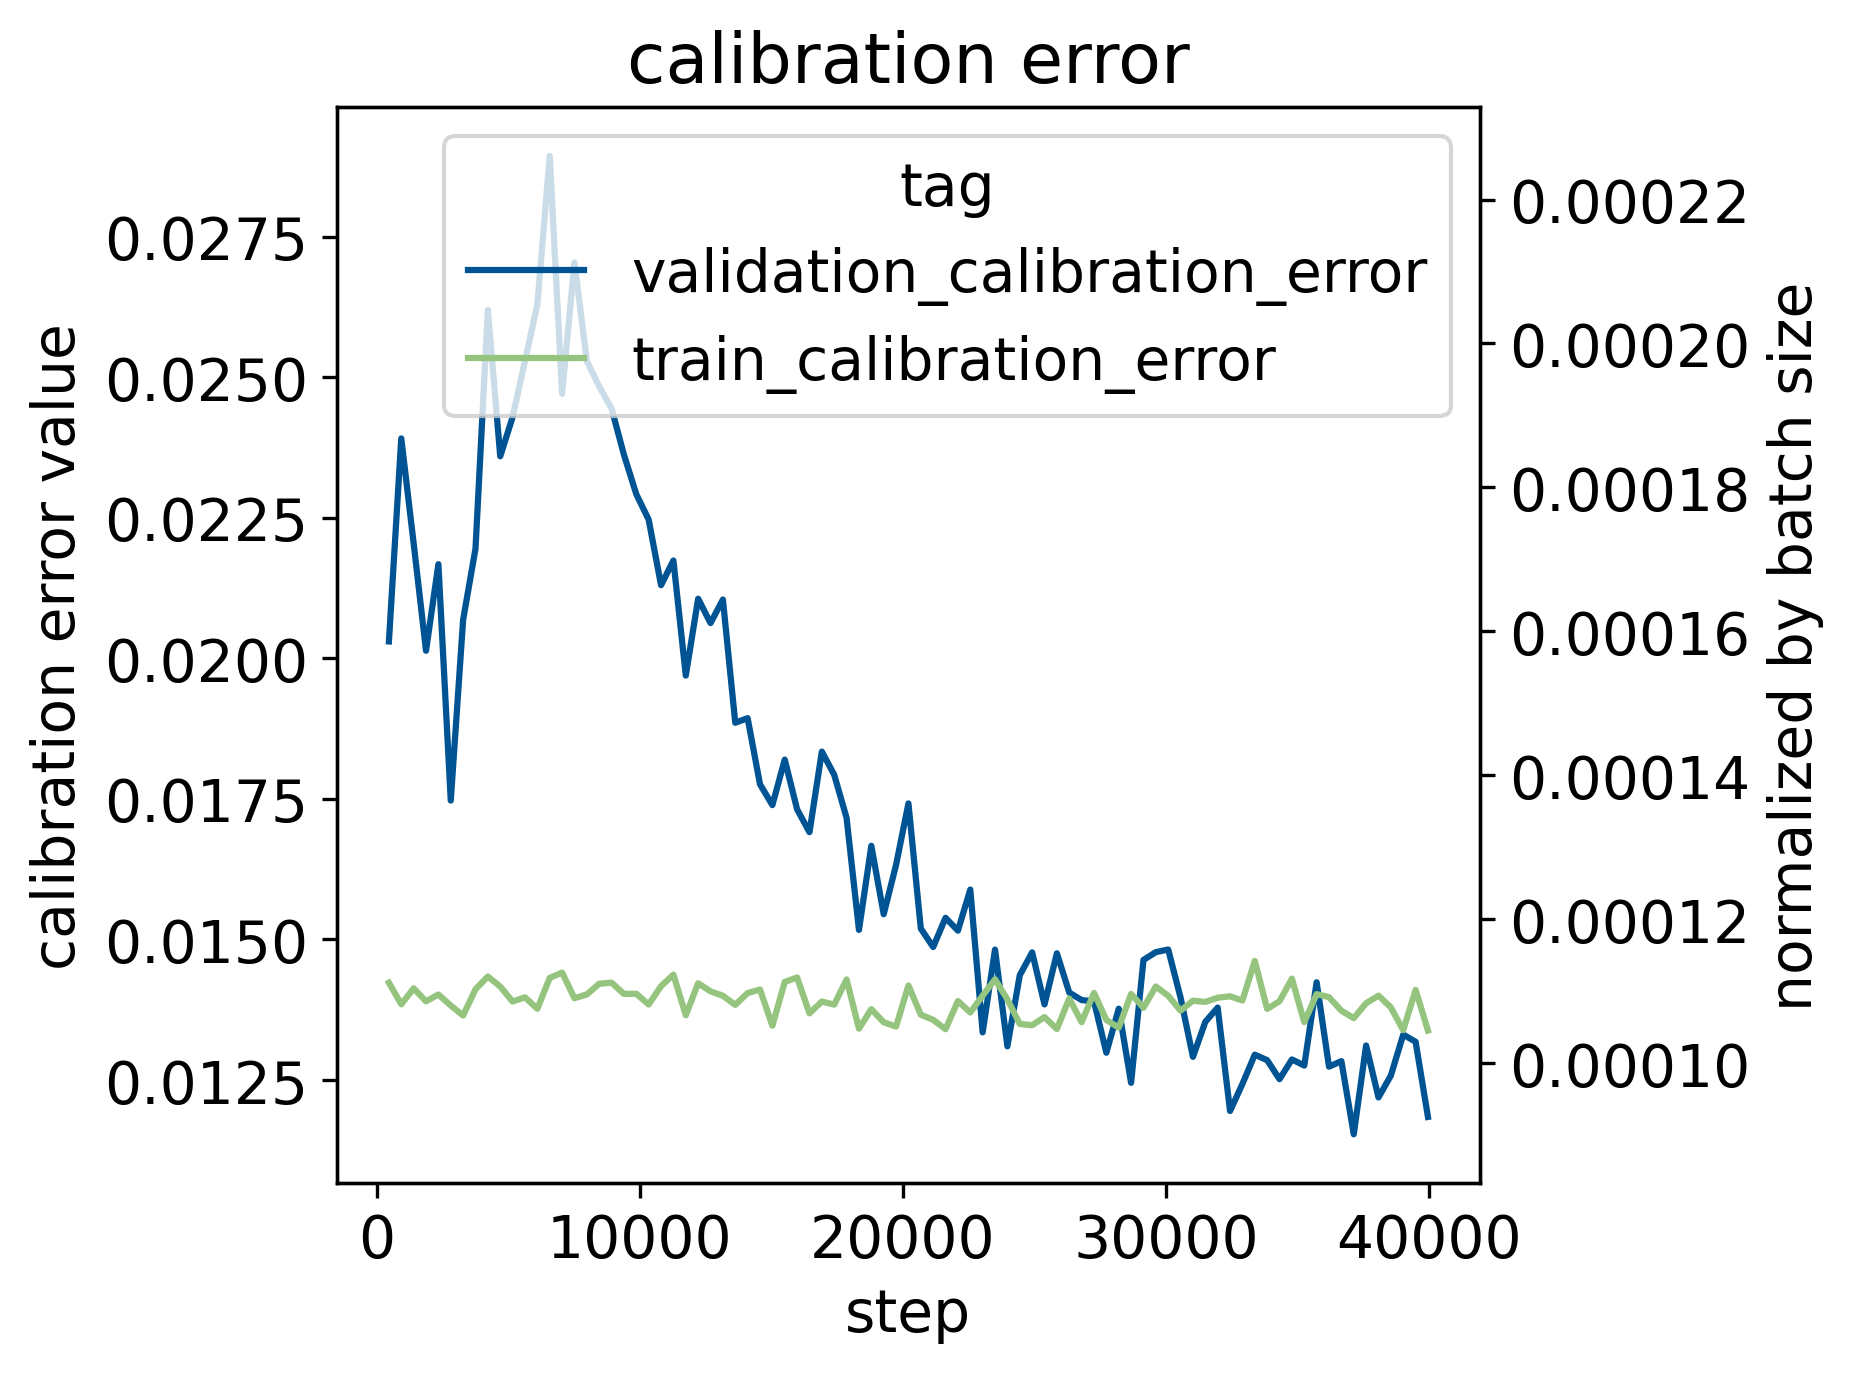

In [37]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

results['general_tag'] = results.tag.str.replace('train', '').str.replace('validation', '').str.strip('_').str.replace('_', ' ')
by_gene_tags = ['reconstruction', 'kl', 'elbo']
no_sec_ax_tags = ['f1', 'accuracy']
pal = ['#005493', '#94c47d']

for gt in results['general_tag'].unique():
    data = results[results.general_tag==gt].copy()
    if data.tag.nunique() < 2:
        continue
    by_gene = np.any([bgt in gt for bgt in by_gene_tags])
    if by_gene:
        sf = 47148
        ylab = 'normalized by number of features'
    else:
        sf = 128
        ylab = 'normalized by batch size'
    
    fig, ax1 = plt.subplots(dpi=300)
    sns.lineplot(data, x='step', y='value', hue='tag', errorbar=('ci', 95), err_style='band', palette=pal, ax=ax1)
    
    ax1.set_title(gt)
    ax1.set_ylabel(f'{gt} value')
    if np.any([bgt in gt for bgt in no_sec_ax_tags]):
        plt.tight_layout()
        plt.show()
        continue
        
    ax2 = ax1.twinx()

    def primary_to_secondary(y):
        return y / sf

    def secondary_to_primary(y_scaled):
        return y_scaled * sf

    # Apply new limits and labels based on existing y-axis
    ymin, ymax = ax1.get_ylim()
    ax2.set_ylim(primary_to_secondary(ymin), primary_to_secondary(ymax))
    ax2.set_ylabel(ylab)

    plt.tight_layout()
    plt.show()

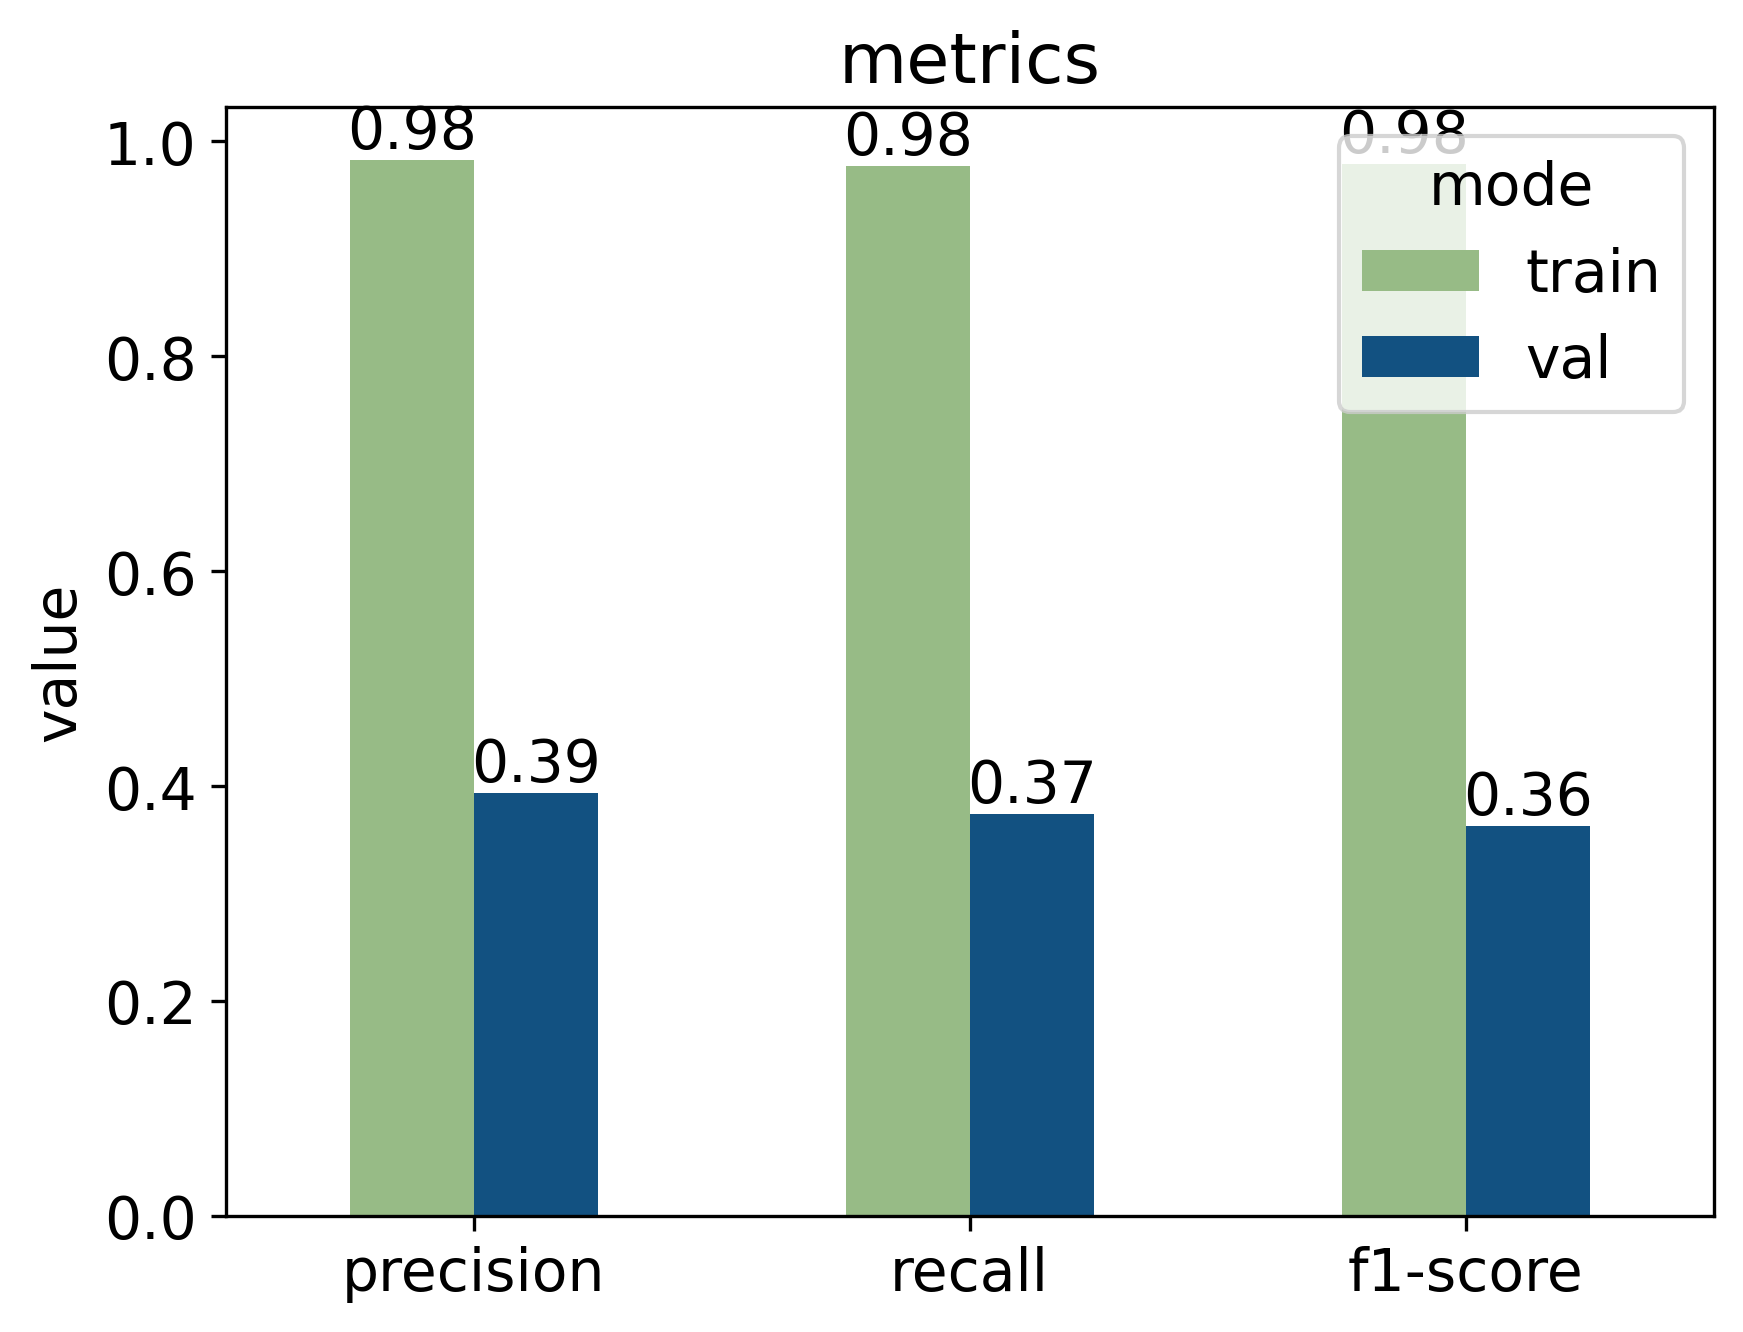

In [33]:
import os

summary = pd.read_csv(os.path.join(log_dir, 'summary.csv'))
summary.columns = ['metric', *summary.columns[1:]]
summary = summary.melt(id_vars=['metric', 'support', 'mode'])
# plot summary stats
fig = plt.figure(dpi=300)

ax = sns.barplot(
    summary[summary.metric=='macro avg'], 
    x='variable', y='value', hue='mode', 
    palette=pal[::-1], width=0.5
)
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f')
plt.xlabel('')
plt.title('metrics')
plt.show()

In [9]:
import scanpy as sc
# Read latent space
latent = sc.read(os.path.join(log_dir, 'latent.h5ad'))

/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `

In [10]:
val_z = latent[latent.obs['mode']=='val']

In [15]:
from src.models._gedvi import GEDVI
# Load model and get soft predictions
model = GEDVI.load(os.path.join(log_dir, 'model'))

INFO     File                                                                   
         /home/xlv0877/proj_home/dl/models/disentangle_losses//rl+kl+c/lightning
         _logs/version_0/model/model.pt already downloaded                      


ValueError: Save path contains no saved anndata and no adata was passed.

In [ ]:
from sklearn.preprocessing import label_binarize

y_true = val_z.obs._scvi_labels
classes = np.unique(val_z.obs._scvi_labels)
y_test_bin = label_binarize(y_true, classes=classes)
n_classes = y_test_bin.shape[1]

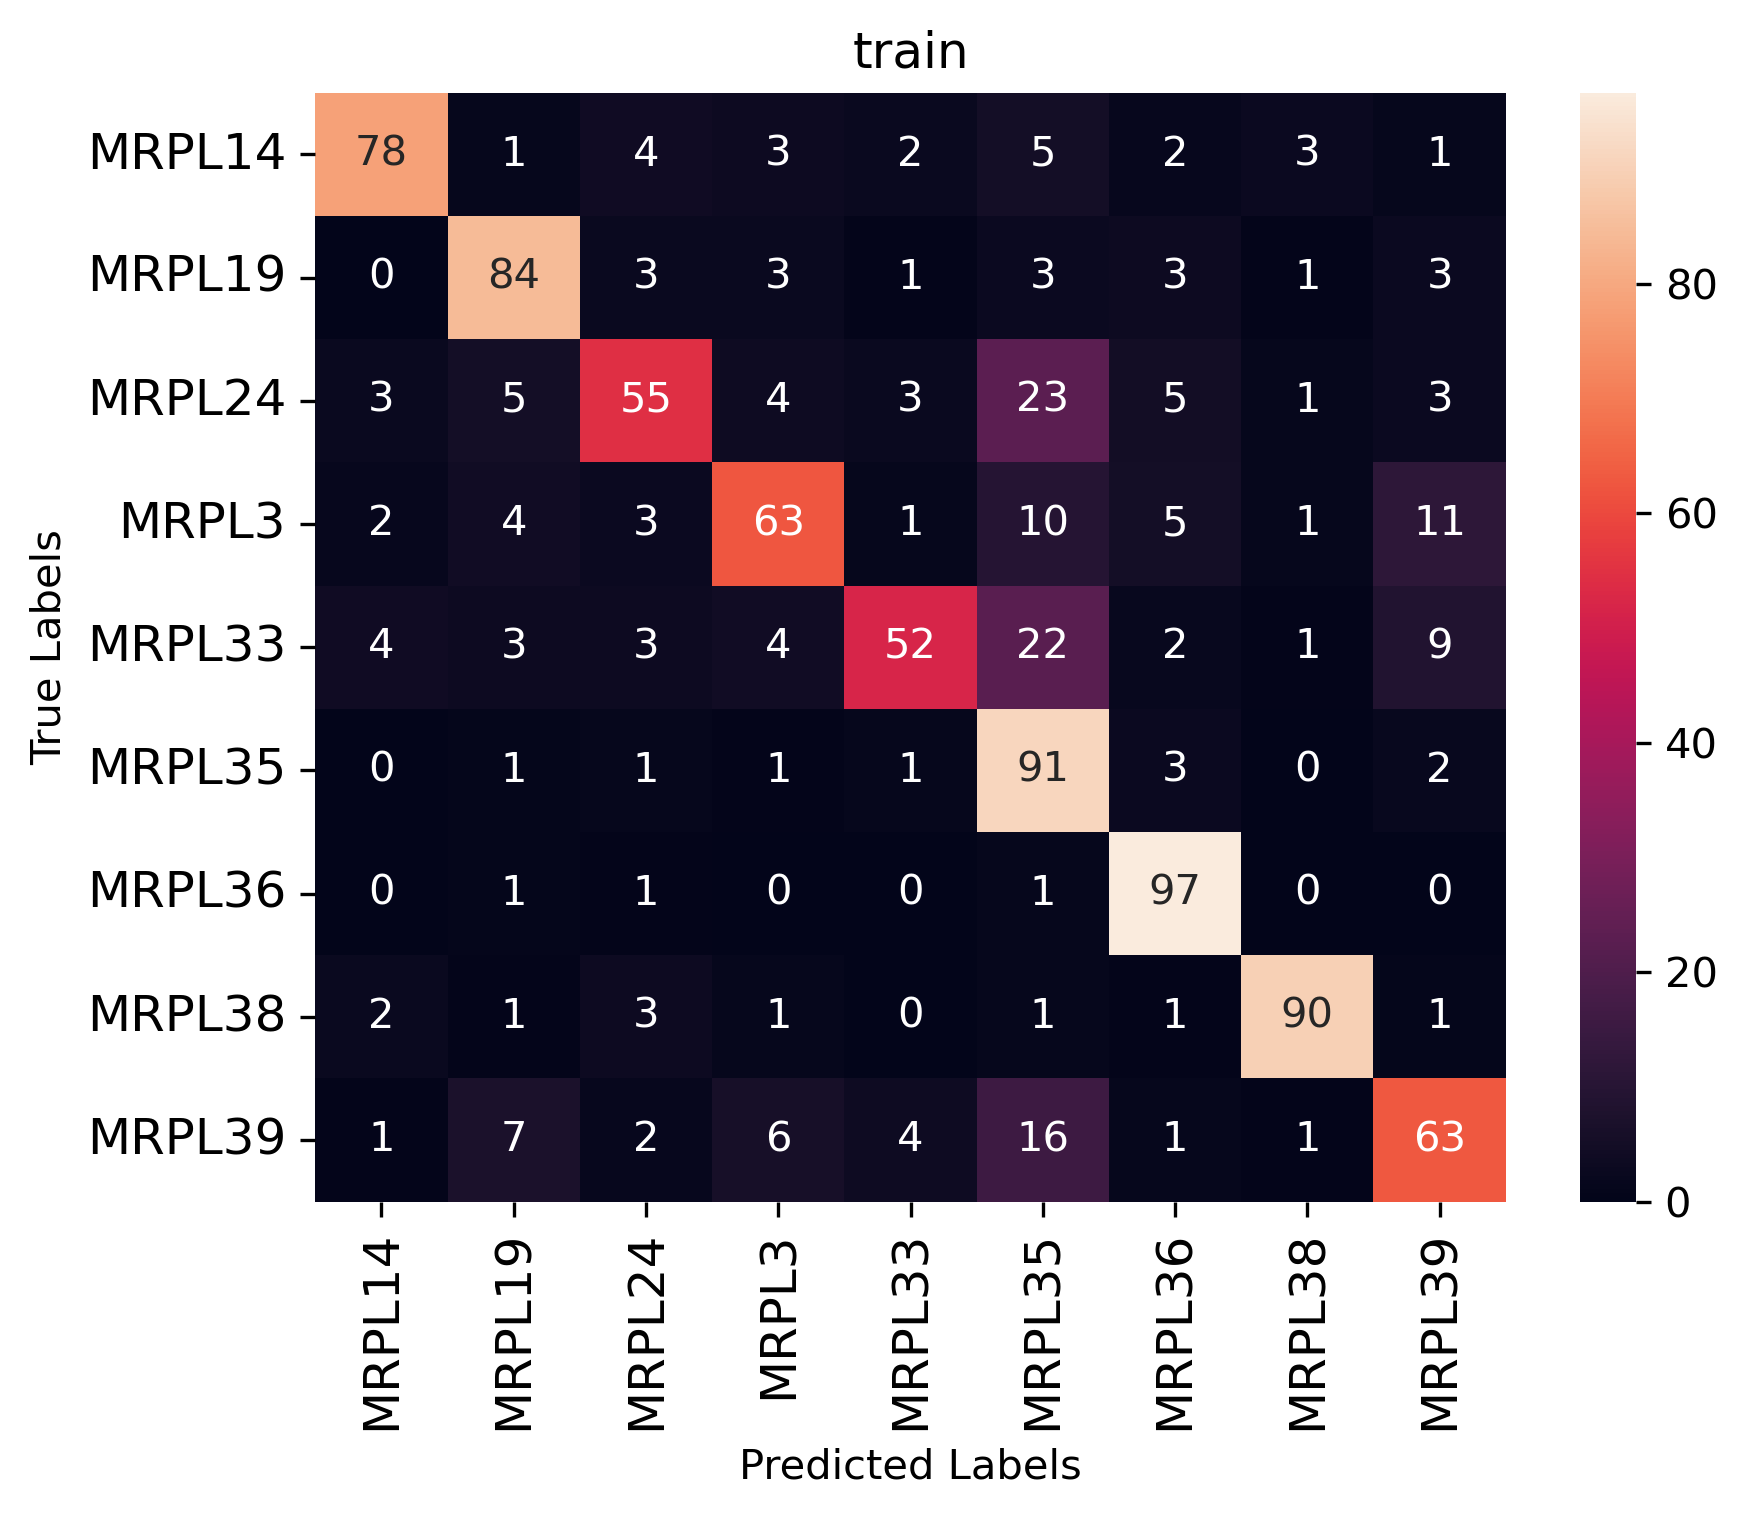

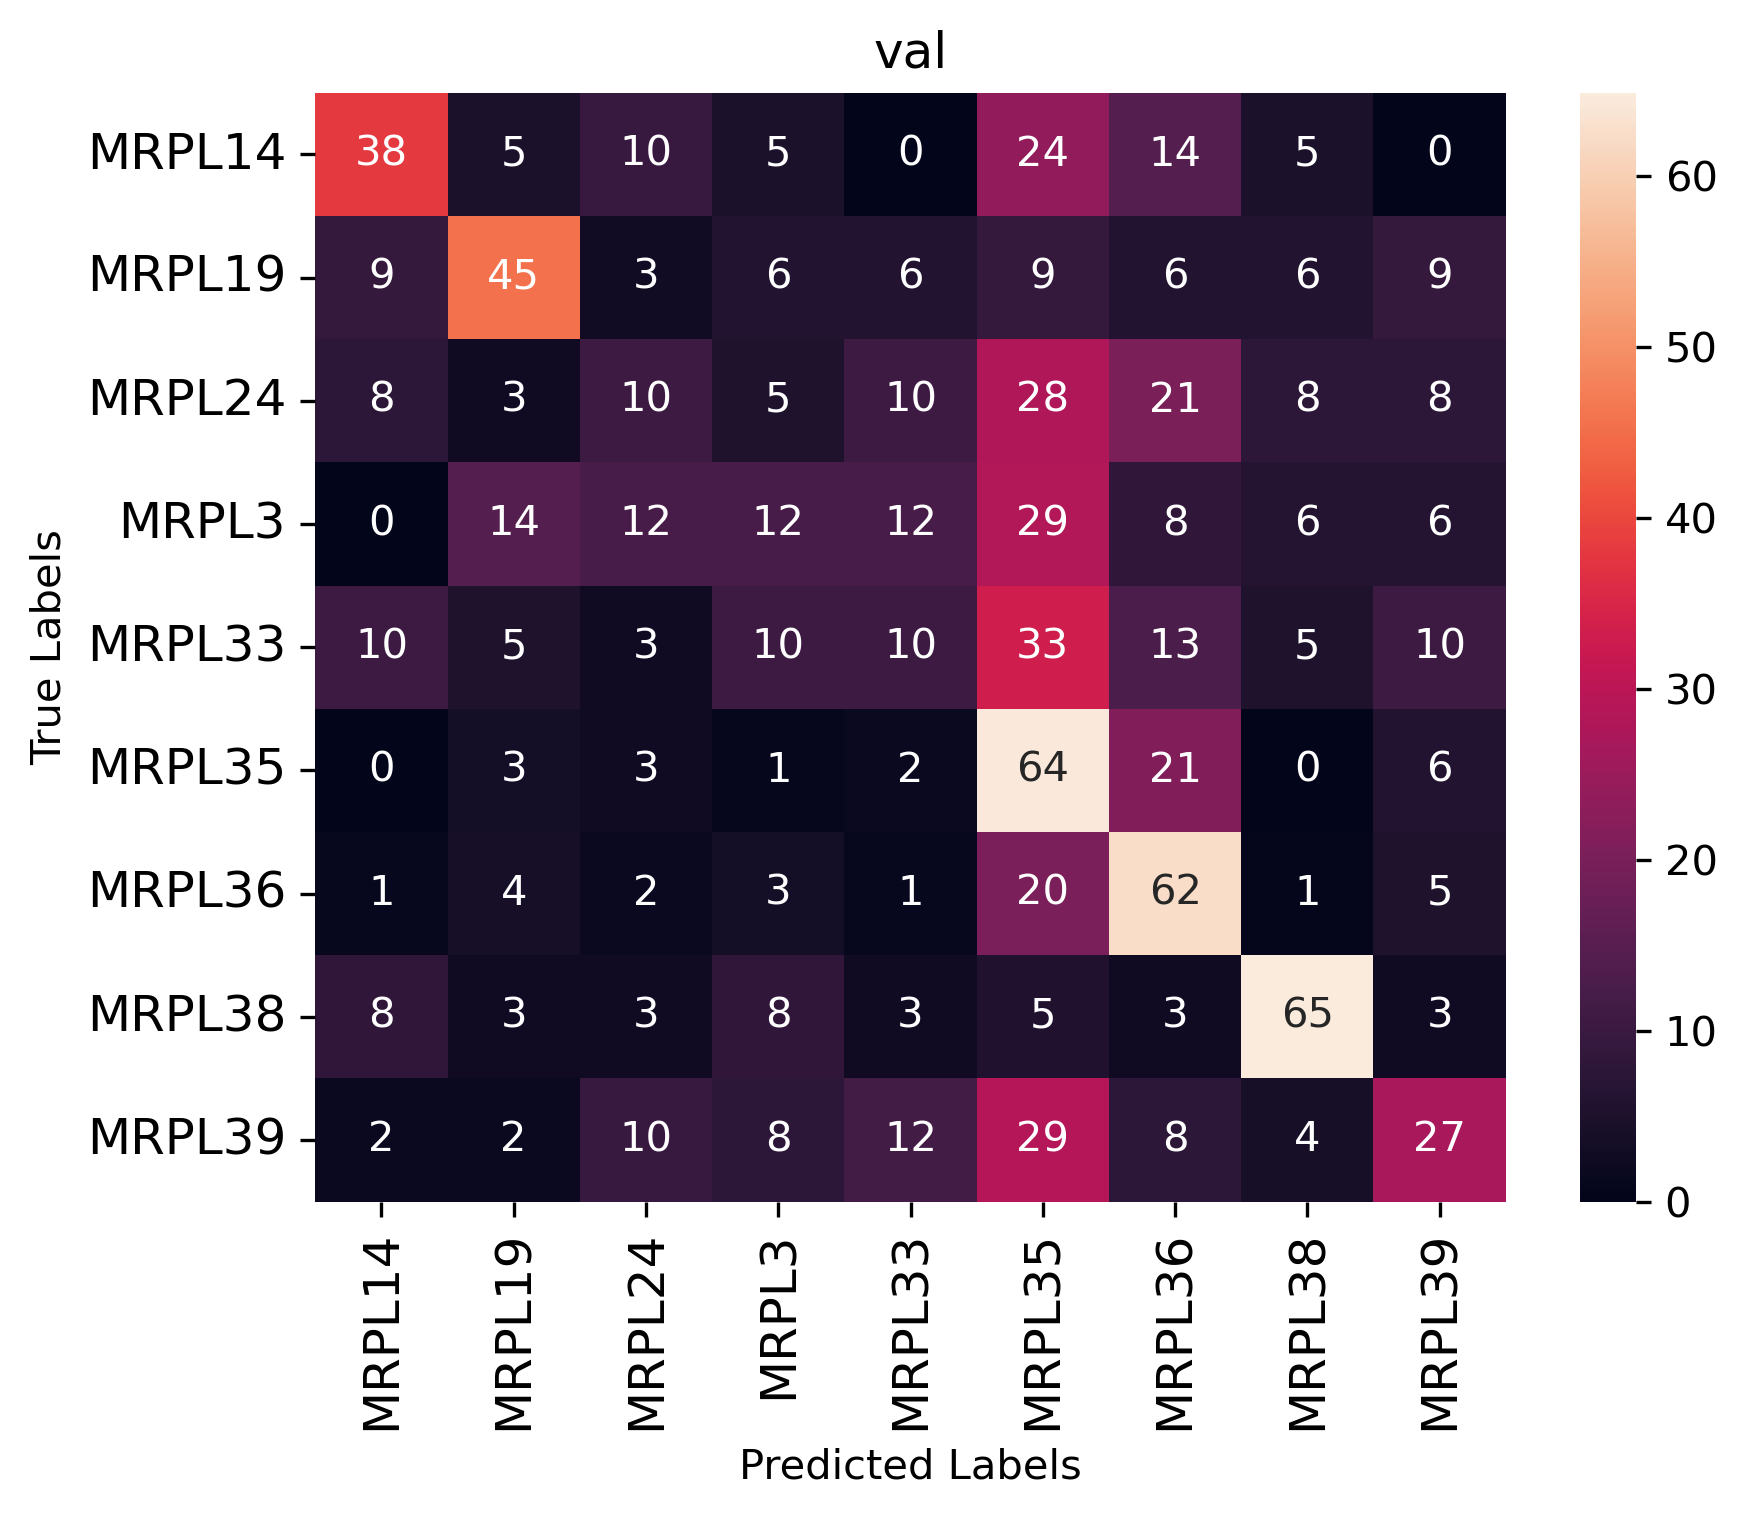

In [113]:
from sklearn.metrics import confusion_matrix

latent = sc.read(os.path.join(log_dir, 'latent.h5ad'))

for mode in latent.obs['mode'].unique():
    l = latent[latent.obs['mode']==mode]
    y_true = l.obs.cls_label.str.split(';').str[-1]
    y_pred = l.obs.scanvi_predictions.str.split(';').str[-1]
    class_labels = np.unique(y_true)
    class_labels = [cl for cl in class_labels if cl.startswith('MRPL')]
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=class_labels)

    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    plt.figure(dpi=300)
    ax = sns.heatmap(
        cm_percentage, 
        xticklabels=class_labels, 
        yticklabels=class_labels, 
        annot=True, 
        fmt='.0f',
        annot_kws={'size': 10}
    )
    ax.tick_params(axis='both', labelsize=12)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(mode)
    plt.show()

In [7]:
def plot_metrics(data, mode='train',
                 targets=['cell_type_acc', 'pert_acc', 'precision', 'recall'],
                 target_labels=['Perturbation precision', 'Perturbation recall', 'Cell type accuracy', 'Perturbation accuracy'],
                 **plot_args):
    targets = [f'{mode}_{t}' for t in targets]
    df = data[data.tag.isin(targets)].copy()
    df.tag = df.tag.str.split('_').str[1:].str.join(' ')
    # plot 
    fig, ax = plt.subplots()
    ax = sns.lineplot(df, x='step', y='value', hue='tag', **plot_args)
    plt.title(f'{mode.capitalize()}. Metrics')
    plt.xlabel('Steps')
    plt.ylabel('Value')
    # Get current legend
    handles, labels = plt.gca().get_legend_handles_labels()
    # Rename the legend labels if alternatives are given
    labels = target_labels if target_labels else labels
    # Reapply the legend with the new labels
    plt.legend(handles=handles, labels=labels, title='Metrics', bbox_to_anchor=(1.5, 0.5), loc='lower center')
    plt.tight_layout()
    plt.minorticks_on()  # Enable minor ticks
    plt.grid(True, which='minor', axis='both', color='gray', linestyle=':', linewidth=0.5)
    plt.show()

In [8]:
results.tag.unique()

array(['train_loss_step', 'epoch', 'train_loss_epoch', 'elbo_train',
       'reconstruction_loss_train', 'kl_local_train', 'kl_global_train',
       'train_classification_loss', 'train_accuracy', 'train_f1_score',
       'train_calibration_error'], dtype=object)

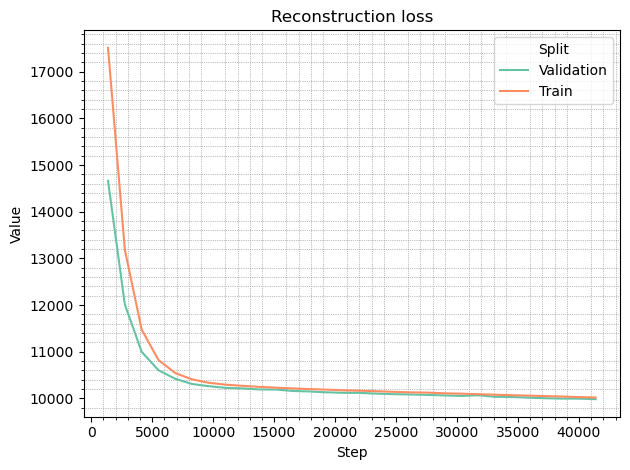

In [38]:
# plot reconstruction loss
pl_df = results[results.tag.str.startswith('reconstruction')].copy()
pl_df.columns = ['Metric', 'Step', 'Value']
pl_df['Split'] = pl_df.Metric.str.split('_').str[2].str.capitalize()

fig, ax = plt.subplots()
sns.lineplot(pl_df, x='Step', y='Value', hue='Split', ax=ax, palette='Set2')
plt.title('Reconstruction loss')
plt.tight_layout()
plt.minorticks_on()
plt.grid(True, which='minor', axis='both', color='gray', linestyle=':', linewidth=0.5)
plt.show()

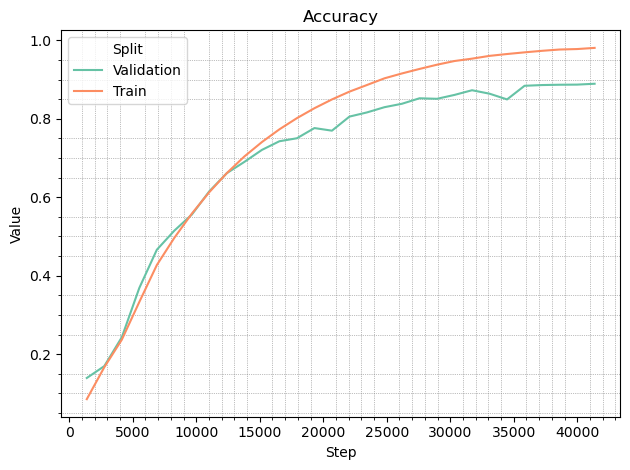

In [35]:
# plot accuracy
pl_df = results[results.tag.str.endswith('accuracy')].copy()
pl_df.columns = ['Metric', 'Step', 'Value']
pl_df['Split'] = pl_df.Metric.str.split('_').str[0].str.capitalize()

fig, ax = plt.subplots()
sns.lineplot(pl_df, x='Step', y='Value', hue='Split', ax=ax, palette='Set2')
plt.title('Accuracy')
plt.tight_layout()
plt.minorticks_on()
plt.grid(True, which='minor', axis='both', color='gray', linestyle=':', linewidth=0.5)
plt.show()

In [7]:
targets = ['accuracy']

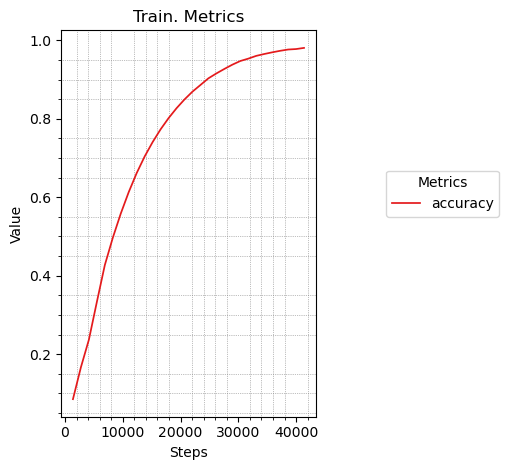

In [8]:
plot_metrics(results, mode='train',
             targets=targets,
             palette='Set1', target_labels=None, linewidth=1.25)

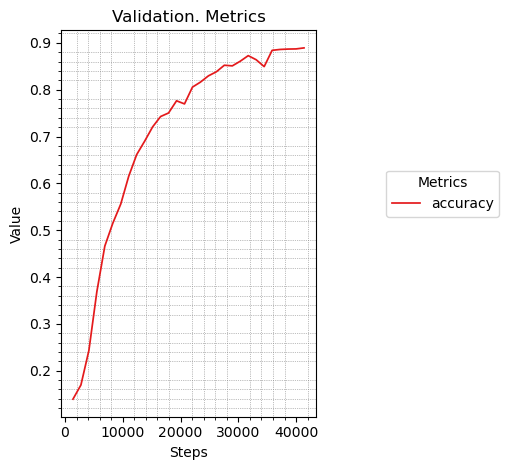

In [9]:
plot_metrics(results, mode='validation',
             targets=targets,
             palette='Set1', target_labels=None, linewidth=1.25)

/tmp/ipykernel_61014/2431898103.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(df, x='step', y='value', hue='tag', **plot_args)
/tmp/ipykernel_61014/2431898103.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(handles=handles, labels=labels, title='Metrics', bbox_to_anchor=(1.5, 0.5), loc='lower center')


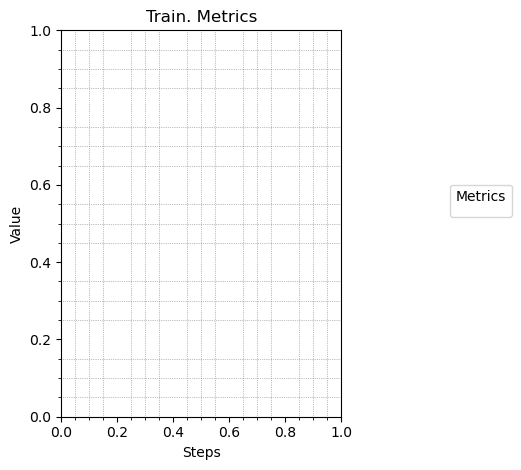

In [9]:
plot_metrics(results, mode='train', palette='Set1', target_labels=None, linewidth=1.25)

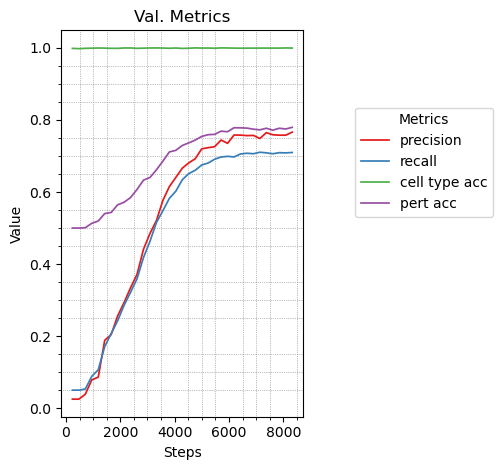

In [24]:
plot_metrics(results, mode='val', palette='Set1', target_labels=None, linewidth=1.25)

In [25]:
loss_targets = results.tag[results.tag.str.startswith('train') & results.tag.str.contains('loss')].str.split('_').str[1:].str.join(sep='_').unique()

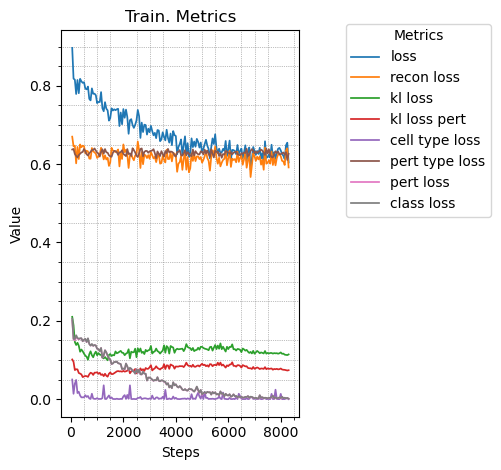

In [26]:
plot_metrics(results, mode='train',
             targets=loss_targets,
             target_labels=None, linewidth=1.25)

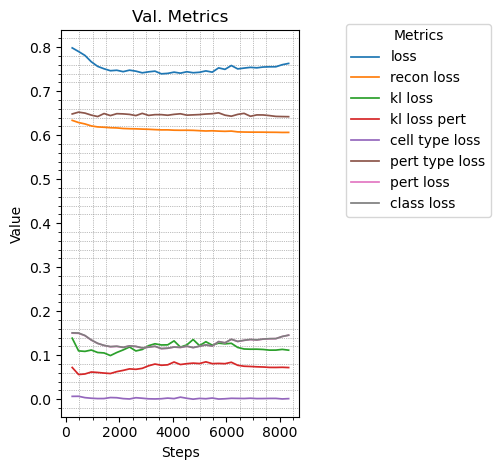

In [27]:
plot_metrics(results, mode='val',
             targets=loss_targets,
             target_labels=None, linewidth=1.25)

In [ ]:
# loading models from checkpoint
use_checkpoint = False

if use_checkpoint:
    from src.multivae import MultiPropertyVAE
    # load model from checkpoint
    checkpoint_p = 'logs/raw/lightning_logs/baba/checkpoints/epoch=3-step=228.ckpt'
    multi_model = MultiPropertyVAE.load_from_checkpoint(checkpoint_p)